# H-1B Visa Petition
## 06:Neural Network Model
**Author:** Prasoon Karmacharya

In [1]:
# !pip list | grep sklearn

In [3]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 3.2MB/s 
     |████████████████████████████████| 6.8MB 5.9MB/s 
  Found existing installation: scikit-learn 0.22
    Uninstalling scikit-learn-0.22:
      Successfully uninstalled scikit-learn-0.22
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [6]:
!pip install scikit-learn==0.22

     |████████████████████████████████| 7.0MB 2.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [1]:
import sklearn
print(sklearn.__version__)


0.23.2


In [29]:
import os, re, time, json
import numpy as np
import pandas as pd
import time



from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

import tensorflow as tf 
from tensorflow.keras import regularizers 
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from imblearn.datasets import make_imbalance
from imblearn.under_sampling import RandomUnderSampler

RANDOM_STATE = 42

In [4]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()

In [5]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.104.223.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.104.223.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.104.223.146:8470']
Number of accelerators:  8


## Connecting to google drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data_folder =  "/content/drive/My Drive/DSI/Portfolio_Colab_Notebooks/data/"
model_folder = "/content/drive/My Drive/DSI/Portfolio_Colab_Notebooks/models/"

## Import data

In [8]:
print("Importing H-1B Data")
try:
  data = pd.read_pickle(data_folder + "cleaned_h1b.pkl")
  print("Successfully, Imported H-1B Data")
except Exception as e:
  print("Unable to import the data")
  print(e)

Importing H-1B Data
Successfully, Imported H-1B Data


### Prepare data

In [9]:
data.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,YEAR_coded,SOC_NAME_coded
0,1,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,0,36067.0,2016.0,"ANN ARBOR, MICHIGAN",5,192
1,1,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,1,242674.0,2016.0,"PLANO, TEXAS",5,297
2,1,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,1,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",5,297
3,1,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",1,220314.0,2016.0,"DENVER, COLORADO",5,297
5,1,BURGER KING CORPORATION,CHIEF EXECUTIVES,"EXECUTIVE V P, GLOBAL DEVELOPMENT AND PRESIDEN...",1,225000.0,2016.0,"MIAMI, FLORIDA",5,297


In [10]:
feature_cols = ['FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR_coded', 'SOC_NAME_coded']
target_col = ['CASE_STATUS']

In [11]:
dev, test = train_test_split(data, test_size=0.15, random_state=RANDOM_STATE)
train, val = train_test_split(dev, test_size=0.15, random_state=RANDOM_STATE)

In [12]:
X_train = train[feature_cols]
y_train = train[target_col]

X_val = val[feature_cols]
y_val = val[target_col]

X_test = test[feature_cols]
y_test = test[target_col]

In [13]:
sampling_strategy = {0:68475, 1:205425}
X_train_balanced, y_train_balanced = make_imbalance(X_train, 
                                                    y_train, 
                                                    sampling_strategy=sampling_strategy, 
                                                    random_state=RANDOM_STATE)

In [14]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
model = Sequential()
model.add(Dense(4, 
					input_dim=4, activation='relu',
					kernel_regularizer=regularizers.l2(0.01), 
					bias_regularizer=regularizers.l2(0.01)))

# model.add(Dense(2,
# 					activation='relu',
# 					kernel_regularizer=regularizers.l2(0.01), 
# 					bias_regularizer=regularizers.l2(0.01)))

model.add(Dense(1, 
					activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), f1_m, "accuracy"])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train_balanced, y_train_balanced, batch_size=16, epochs=10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
    1/17119 [..............................] - ETA: 39:41 - loss: 15180.9375 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1_m: 0.0000e+00 - accuracy: 0.4375WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_train_batch_end` time: 0.0195s). Check your callbacks.


17119/17119 [==============================] - ETA: 0s - loss: 471.1576 - recall: 0.6561 - precision: 0.7613 - f1_m: 0.6338 - accuracy: 0.5878WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_test_batch_end` time: 0.0088s). Check your callbacks.


17119/17119 [==============================] - 578s 34ms/step - loss: 471.1576 - recall: 0.6561 - precision: 0.7613 - f1_m: 0.6338 - accuracy: 0.5878 - val_loss: 25.2696 - val_recall: 0.8671 - val_precision: 0.9695 - val_f1_m: 0.9127 - val_accuracy: 0.8450
Epoch 2/10
17119/17119 [==============================] - 571s 33ms/step - loss: 385.5424 - recall: 0.7031 - precision: 0.7685 - f1_m: 0.6775 - accuracy: 0.6185 - val_loss: 22.8176 - val_recall: 0.9358 - val_precision: 0.9701 - val_f1_m: 0.9510 - val_accuracy: 0.9100
Epoch 3/10
17119/17119 [==============================] - 576s 34ms/step - loss: 319.9366 - recall: 0.7305 - precision: 0.7698 - f1_m: 0.7006 - accuracy: 0.6341 - val_loss: 6.2898 - val_recall: 0.7762 - val_precision: 0.9709 - val_f1_m: 0.8583 - val_accuracy: 0.7608
Epoch 4/10
17119/17119 [==============================] - 567s 33ms/step - loss: 314.7671 - recall: 0.7245 - precision: 0.7702 - f1_m: 0.6947 - accuracy: 0.6312 - val_loss: 1.5771 - val_recall: 0.9056 - val_p

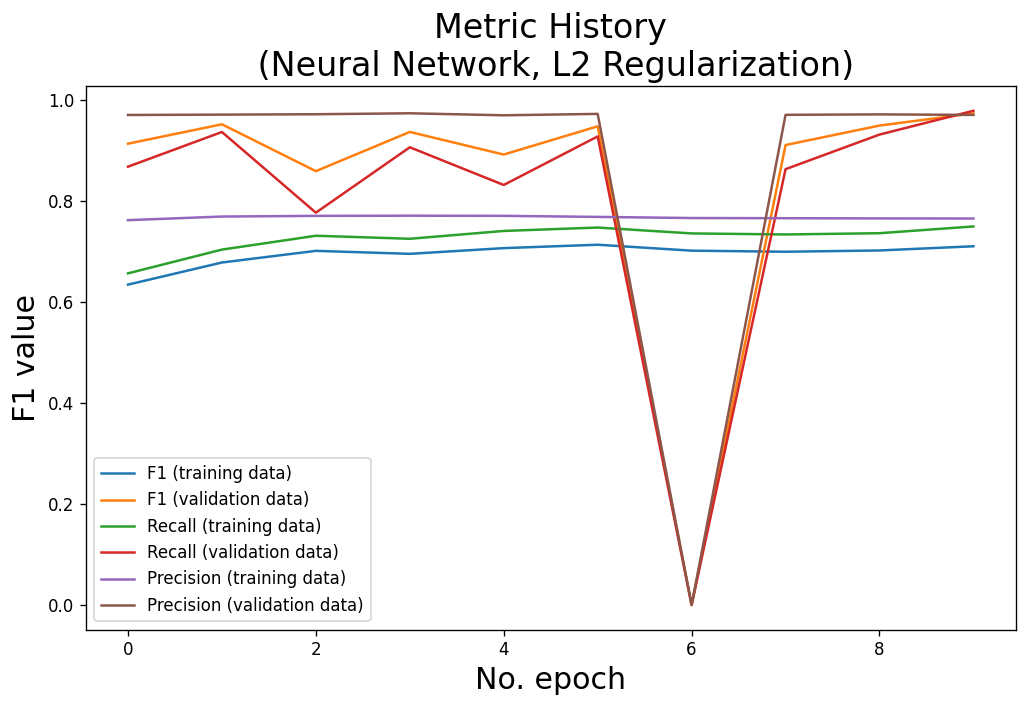

In [121]:
#history
# Plot history: F1
plt.figure(figsize=(10,6), dpi=120)
plt.plot(history.history['f1_m'], label='F1 (training data)')
plt.plot(history.history['val_f1_m'], label='F1 (validation data)')
plt.plot(history.history['recall'], label='Recall (training data)')
plt.plot(history.history['val_recall'], label='Recall (validation data)')
plt.plot(history.history['precision'], label='Precision (training data)')
plt.plot(history.history['val_precision'], label='Precision (validation data)')
plt.title('Metric History\n (Neural Network, L2 Regularization)', fontsize=20)
plt.ylabel('F1 value',fontsize=18)
plt.xlabel('No. epoch', fontsize=18)
plt.legend(loc="lower left")
plt.show()

In [18]:
# estimator = KerasClassifier(build_fn=create_baseline, epochs=10, batch_size=5, verbose=0)

In [35]:
# Confusio matrix
y_pred = model.predict(X_test)
y_pred = [1 * (x[0]>=0.5) for x in y_pred]

In [36]:
cm = confusion_matrix(y_test, y_pred)

In [37]:
cm

array([[  1057,  12896],
       [  9345, 411111]])

In [101]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize=16)
    plt.yticks(tick_marks, classes, rotation=90, fontsize=16)

    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Normalized confusion matrix")
    # else:
    #     # print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=16)

    
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.title("Neural Network \n (L2 regularization)", fontsize=20)


    plt.tight_layout()

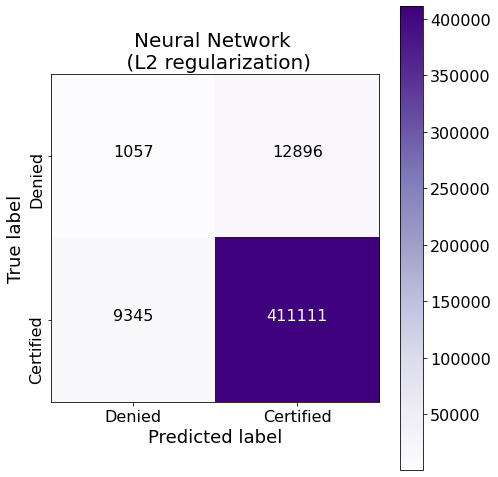

In [102]:
cm_plot_labels = ['Denied', 'Certified']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Model Architecture

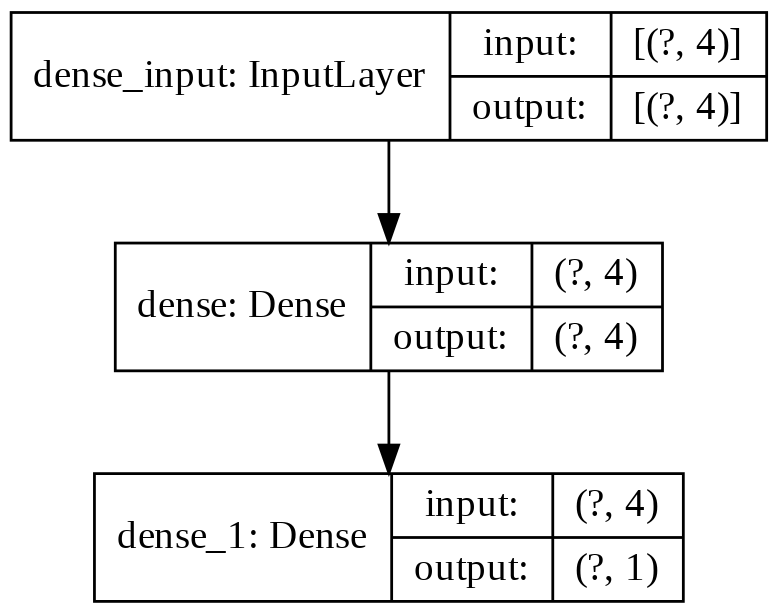

In [107]:
tf.keras.utils.plot_model(
    model,
    to_file="NN_with_L2_regularization_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=200,
)